<a href="https://colab.research.google.com/github/sleepyMS/Ai-Development-Collection/blob/main/GCCE2024_Crypto_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import pandas as pd
import numpy as np
import pprint
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


## Data init

In [ ]:
df_btc = pd.read_csv('./BINANCE_BTCUSDT, 1D.csv')
df_doge = pd.read_csv('./BINANCE_DOGEUSDT, 1D.csv')
df_eth = pd.read_csv('./BINANCE_ETHUSDT, 1D.csv')
df_ltc = pd.read_csv('./BINANCE_LTCUSDT, 1D.csv')
df_xrp = pd.read_csv('./BINANCE_XRPUSDT, 1D.csv')

In [ ]:
# 대상 코인 df
df = df_xrp.iloc[:,1:]
df_close = pd.DataFrame(df.iloc[:, 3], columns=['close'])

# 실제 테스트 결과 데이터 수익률 확인
result_test = [{'high': df['high'][i], 'low': df['low'][i], 'close': df['close'][i]} for i in range(len(df))]

# 개선된 목표 데이터
improve_close = [df['close'][0]]
for i in range(1, len(df)):
  if df['close'][i-1] < df['close'][i]:
    improve_close.append(df['high'][i])
  elif df['close'][i-1] > df['close'][i]:
    improve_close.append(df['low'][i])
  else:
    improve_close.append(df['close'][i])

# 개선된 목표 데이터 (Ver.array)
improve_close = np.array(improve_close)
# 개선된 목표 데이터 (Ver.df)
df_model = pd.DataFrame(improve_close, columns=['improve'])

## Min Max Scaling

In [ ]:
# 두 데이터프레임을 결합
combined_df = pd.concat([df, df_model], axis=1)

# 결합된 데이터프레임에 스케일링 적용
scaler = MinMaxScaler()
scaler.fit(combined_df)
combined_scaled = scaler.transform(combined_df)

# combined_scaled

## Batch data 제작

In [ ]:
# 3 : 종가, 9 : 개선 데이터
majorData = 9

x = combined_scaled[:, [0,1,2,3]].copy()
y = combined_scaled[:, majorData].copy()

scaler = MinMaxScaler()
if majorData == 9:
  # 결과 출력을 위한 fit 처리 (Ver.improve)
  y_fit = y.reshape(len(y),1)
  scaler.fit(df_model)
elif majorData == 3:
  # 결과 출력을 위한 fit 처리 (Ver.close)
  y_fit = y.reshape(len(y),1)
  scaler.fit(df_close)


In [ ]:
# 타임 스탬프 길이
timestemps = 14

x_seq = []
y_seq = []
result_seq = []

for i in range(len(y) - timestemps):
  x_seq.append(x[i:i+timestemps, :])
  y_seq.append(y[i+timestemps])
  result_seq.append(result_test[i+timestemps])

x_seq = np.array(x_seq)
y_seq = np.array(y_seq)
result_seq = np.array(result_seq)

x_seq.shape, y_seq.shape, result_seq.shape

((1416, 14, 4), (1416,), (1416,))

In [ ]:
train_size = int(len(x_seq) * 0.6)
val_size = int(len(x_seq) * 0.2)

In [ ]:
x_train = x_seq[:train_size].copy()
y_train = y_seq[:train_size].copy()
x_val = x_seq[train_size:train_size+val_size].copy()
y_val = y_seq[train_size:train_size+val_size].copy()
x_test = x_seq[train_size+val_size:].copy()
y_test = y_seq[train_size+val_size:].copy()

result_seq = result_seq[train_size+val_size:].copy()

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((849, 14, 4), (849,), (283, 14, 4), (283,), (284, 14, 4), (284,))

## Model Trainig

In [ ]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse, MeanSquaredError, huber, mae
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
clear_session()

# 모델 정의
model = Sequential([
    LSTM(256, input_shape=x_seq[0].shape, return_sequences=True),
    Dropout(0.05),
    # BatchNormalization(),
    LSTM(128, return_sequences=False),
    Dropout(0.05),
    # BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(1)
])

# 옵티마이저와 손실 함수 정의
opt = Adam(learning_rate=0.001)
loss = MeanSquaredError()

# 모델 컴파일
model.compile(loss=loss, optimizer=opt, metrics=['mse'])
model.summary()

# 조기 종료 콜백 생성
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# 최적 모델 저장 콜백 생성
# model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# 모델 훈련 시 콜백 추가
model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=1, validation_data=(x_val, y_val), callbacks=[early_stopping])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 256)           267264    
                                                                 
 dropout (Dropout)           (None, 14, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 472705 (1.80 MB)
Trainable params: 472705 

In [ ]:
y_pred = model.predict(x_test)

9/9 [==============================] - 1s 3ms/step


## Result Solution

In [ ]:
# 스케일링된 데이터를 원래 값으로 되돌리기
test_ori = y_test.reshape(len(y_test), 1)
pred_ori = y_pred.reshape(len(y_pred), 1)
test_ori = scaler.inverse_transform(test_ori)
pred_ori = scaler.inverse_transform(pred_ori)
test_ori = test_ori.ravel()
pred_ori = pred_ori.ravel()

revenue = 1 # 수익률
long_pos, short_pos = {'win': 0, 'los': 0}, {'win': 0, 'los': 0}  # 승패

if majorData == 3 or majorData == 9:
  ######################## 종가 데이터의 수익률 예측 ########################
  for i in range(1, len(y_pred)):
    # 롱 포지션일때
    if result_seq[i-1]['close'] < pred_ori[i]:
      # 당일 예측가보다 최고가가 크다면
      if pred_ori[i] <= result_seq[i]['high']:
        revenue *= (1 + abs(pred_ori[i] - result_seq[i-1]['close']) / result_seq[i-1]['close'])
        long_pos['win'] += 1
      # 전일대비 가격이 상승했다면
      elif result_seq[i-1]['close'] < result_seq[i]['close']:
        revenue *= (1 + abs(result_seq[i]['close'] - result_seq[i-1]['close']) / result_seq[i-1]['close'])
        long_pos['win'] += 1
      # 전일대비 가격이 하락했다면
      elif result_seq[i-1]['close'] > result_seq[i]['close']:
        revenue *= (1 - abs(result_seq[i]['close'] - result_seq[i-1]['close']) / result_seq[i-1]['close'])
        long_pos['los'] += 1
    # 숏 포지션일때
    elif result_seq[i-1]['close'] > pred_ori[i]:
      # 당일 예측가보다 최저가가 작다면
      if pred_ori[i] >= result_seq[i]['low']:
        revenue *= (1 + abs(pred_ori[i] - result_seq[i-1]['close']) / result_seq[i-1]['close'])
        short_pos['win'] += 1
      # 전일대비 가격이 상승했다면
      elif result_seq[i-1]['close'] < result_seq[i]['close']:
        revenue *= (1 - abs(result_seq[i]['close'] - result_seq[i-1]['close']) / result_seq[i-1]['close'])
        short_pos['los'] += 1
      # 전일대비 가격이 하락했다면
      elif result_seq[i-1]['close'] > result_seq[i]['close']:
        revenue *= (1 + abs(result_seq[i]['close'] - result_seq[i-1]['close']) / result_seq[i-1]['close'])
        short_pos['win'] += 1
  ###########################################################################

rate = (long_pos['win'] + short_pos['win']) / (long_pos['win'] + long_pos['los'] + short_pos['win'] + short_pos['los'])

long_pos, short_pos, round(rate, 3), revenue

({'win': 51, 'los': 16}, {'win': 161, 'los': 54}, 0.752, 1.9450392263504435)

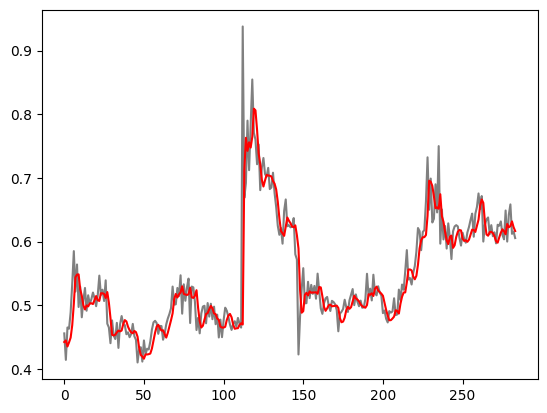

In [ ]:
plt.figure()
plt.plot(test_ori, color='gray')
plt.plot(pred_ori, color='red')
plt.show()

In [ ]:
# y_pred를 1차원 배열로 변환합니다.
y_pred = y_pred.reshape(-1)
# scipy의 pearsonr 함수를 사용하여 피어슨 상관계수를 계산합니다.
corr, _ = pearsonr(y_pred, y_test)
print("Pearson correlation: %.3f" % corr)

Pearson correlation: 0.893
